In [2]:
import os
genome = os.path.basename(os.getcwd())
hub_path = os.path.join(os.getcwd(), genome + '_hub')
scaffold_2bit = '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/scaffolded.2bit'

In [8]:
# run bwa
!samtools fastq  {genome}.consensus_mapped.sorted.bam > consensus_reads.fq
!bwa mem -t 8 /hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/hg38_scaffolded_contigs/combined.fa consensus_reads.fq > combined_scaffold_mapped.sam 

[M::bam2fq_mainloop] processed 995798 reads
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 573476 sequences (80000247 bp)...
[M::process] read 422322 sequences (58913574 bp)...
[M::mem_process_seqs] Processed 573476 reads in 201.593 CPU sec, 25.139 real sec
[M::mem_process_seqs] Processed 422322 reads in 167.400 CPU sec, 20.844 real sec
[main] Version: 0.7.12-r1044
[main] CMD: bwa mem -t 8 /hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/hg38_scaffolded_contigs/combined.fa consensus_reads.fq
[main] Real time: 47.269 sec; CPU: 370.256 sec


In [3]:
# load barcode map
bcode_map = {}
for x in open('{}.sorted.fastq'.format(genome)):
    if x.startswith('@'):
        name, bcode = x.split()
        name = name[1:-2]
        bcode_map[name] = bcode

In [4]:
# divide reads by barcode
import pysam
from collections import *
s = defaultdict(list)
for x in pysam.Samfile('combined_scaffold_mapped.sam'):
    if not x.is_unmapped:
        bcode = bcode_map[x.qname]
        s[bcode].append(x)

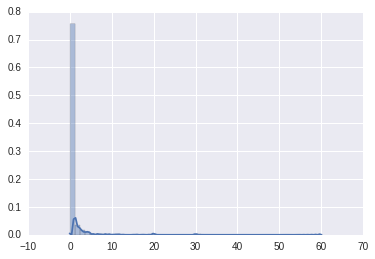

In [5]:
# plot the average and sum of each barcode
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

avg = [np.mean([x.mapq for x in y]) for y in s.itervalues()]
#tot = [sum([x.mapq for x in y]) for y in s.itervalues()]
sns.distplot(avg)
#sns.distplot(tot)

In [6]:
# find haplotype with highest average mapq
by_avg = {}
for bcode, reads in s.iteritems():
    by_tgt = defaultdict(list)
    for r in reads:
        by_tgt[r.reference_name].append([r, r.mapq])
    avgs = {}
    for rname, rname_vals in by_tgt.iteritems():
        rname_reads, mapqs = zip(*rname_vals)
        avgs[rname] = np.mean(mapqs)
    if all(x == 0 for x in avgs.itervalues()):
        continue
    ordered = sorted(avgs.iteritems(), key=lambda x:x[1])
    best_name, best_score = ordered[-1]
    if len(ordered) > 1 and best_score > ordered[-2][1]:
        mappings = [x for x in reads if x.reference_name == best_name]
        by_avg[bcode] = mappings

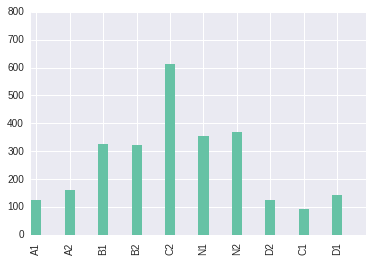

In [7]:
import pandas as pd
# distribution by name?
hits = []
for x in by_avg.itervalues():
    hits.append(x[0].reference_name)

df = pd.DataFrame.from_dict(Counter(hits).items())
df = df.set_index(0).T
fig, ax = plt.subplots()
bars = []
cumulative = np.zeros(len(df.columns))
color_palette = sns.color_palette("Set2", 10)
for i, (_, d) in enumerate(df.iterrows()):
    bars.append(ax.bar(np.arange(len(df.columns)), d, 0.3, bottom=cumulative,
                       color=color_palette[i], linewidth=0.0))
    cumulative += d
names = df.columns
import matplotlib
ax.margins(y=0.15)
ax.autoscale(enable=True, axis='y', tight=False)
ax.set_ylim(0, plt.ylim()[1])
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10], integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(len(names)))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.xaxis.set_ticklabels(names, rotation=90)
ax.xaxis.set_ticks(np.arange(0, len(names)) + 0.3 / 2.0)

In [8]:
# construct a separate BAM for each of these putative haplotypes
# reshape to be by-reference
by_reference = defaultdict(list)
for x in by_avg.itervalues():
    for y in x:
        by_reference[y.reference_name].append(y)

        
sh = pysam.Samfile('combined_scaffold_mapped.sam')
for name, reads in by_reference.iteritems():
    with pysam.Samfile(name + '.bam', 'wb', template=sh) as outf:
        for x in reads:
            outf.write(x)

In [9]:
%%bash
# generate a coverage plot
for f in *{1,2}.bam; do
    sambamba sort -o ${f}.sorted ${f}
    samtools index ${f}.sorted
    bamCoverage -b ${f}.sorted -o ${f}.bw --binSize 5
done

verbose: False
out_file_for_raw_data: None
numberOfSamples: None
bedFile: None
bamFilesList: ['A1.bam.sorted']
ignoreDuplicates: False
numberOfProcessors: 32
samFlag_exclude: None
save_data: False
blackList: None
stepSize: 5
smoothLength: None
center_read: False
defaultFragmentLength: read length
chrsToSkip: []
region: None
maxPairedFragmentLength: 1000
samFlag_include: None
binLength: 5
blackListFileName: None
minMappingQuality: None
zerosToNans: False
verbose: False
out_file_for_raw_data: None
numberOfSamples: None
bedFile: None
bamFilesList: ['B1.bam.sorted']
ignoreDuplicates: False
numberOfProcessors: 32
samFlag_exclude: None
save_data: False
blackList: None
stepSize: 5
smoothLength: None
center_read: False
defaultFragmentLength: read length
chrsToSkip: []
region: None
maxPairedFragmentLength: 1000
samFlag_include: None
binLength: 5
blackListFileName: None
minMappingQuality: None
zerosToNans: False
verbose: False
out_file_for_raw_data: None
numberOfSamples: None
bedFile: None
bamFi

In [12]:
# create a new hub

hub_str = '''hub {0}_H9_comparison
shortLabel {1} H9 comparison
longLabel {1} H9 comparison
genomesFile genomes.txt
email NoEmail

'''

genomes_str = '''genome H9_assemblies
twoBitPath H9/H9.2bit
trackDb H9/trackDb.txt
organism H9
description H9 wildtype comparison
scientificName H9
defaultPos A1:1-10000000

'''

composite = '''track {0}
compositeTrack on
shortLabel {0} barcode assignments
longLabel {0} barcode assignments
type bigWig
visibility full

'''

template = '''track {1}_{0}
type bigWig
parent {1}
shortLabel {0}
longLabel {0}
visibility full
bigDataUrl {1}_{2}

'''

from tools.fileOps import *
ensure_dir(os.path.join(hub_path, 'consensus'))

with open(os.path.join(hub_path, 'hub.txt'), 'w') as outf:
    outf.write(hub_str.format(genome))

with open(os.path.join(hub_path, 'consensus', 'trackDb.txt'), 'a') as outf:
    bws = sorted([x for x in os.listdir('.') if x.endswith('bw')])
    outf.write(composite.format(genome))
    for f in bws:
        t = f.split('.')[0]
        outf.write(template.format(t, genome, f))
        os.link(f, os.path.join(hub_path, 'consensus', '{}_{}'.format(genome, f)))